In [ ]:
%matplotlib inline
import mpld3
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
conn = psycopg2.connect('dbname=info1903 user=lyneca')
cur = conn.cursor()

mpld3.enable_notebook()

query = """
select rainfall, fatalities, rainfall.year, rainfall.month, rainfall.day                            
  from crashes, rainfall                                                
 where rainfall.year = crashes.year                                      
   and rainfall.month = extract(MONTH from to_date(concat(crashes.month, ' 2000'), 'Month YYYY'))                                                
   and rainfall.day = crashes.day
   and rainfall.rainfall is not null
   and crashes.fatalities is not null
   and crashes.state = 'STATE';
   """

# Select states that will be graphed
#  (data uses only victorian rainfall)
states = [
#     'NSW',
    'VIC',
#     'QLD',
#     'WA',
#     'NT',
#     'SA',
#     'TAS',
]

# Generate per-state queries
queries = {x: query.replace("STATE", x) for x in states}


## Generating the fatality/rainfall graph

Processing VIC... done.
Processing rain graph... done.


9127255

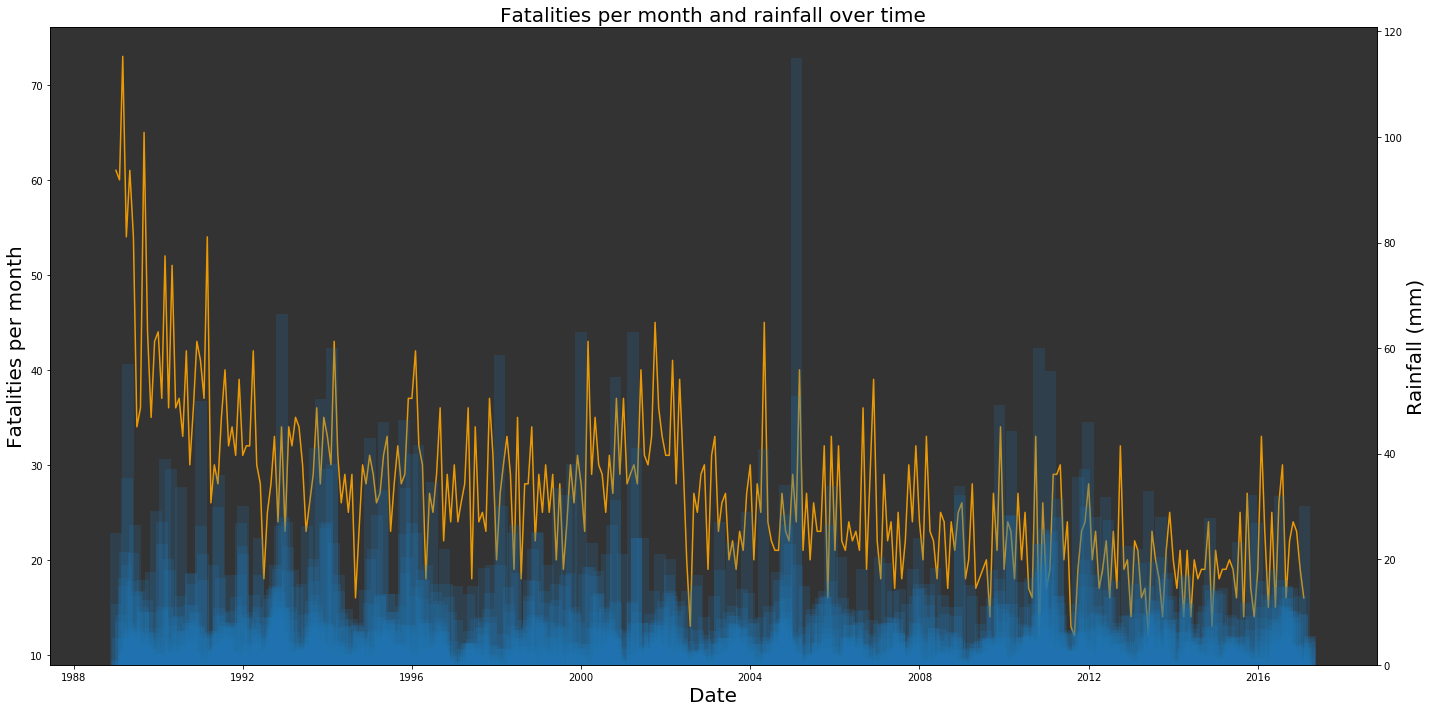

In [15]:
from functools import lru_cache

fig, ax = plt.subplots(figsize=(20, 10))
c = 0.2
ax.set_facecolor((c, c, c, 1))
fig.set_facecolor((1, 1, 1, 1))

plt.title("Fatalities per month and rainfall over time",fontsize=20)

ax.set_ylabel("Fatalities per month", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.xaxis_date()  # Format x axis as dates

max_year = 2017
min_year = 1989


# Collect all rainfall data to graph
#  (previously I only graphed data where there was a crash,
#   leading to an inaccurate graph)

cur.execute(f"""
    select rainfall, year, month, day
      from rainfall
    where year >= {min_year}
      and year <= {max_year}
    order by year, month, day;
""")
r_data = cur.fetchall()

r_rainfall = [(0 if x[0] is None else x[0]) for x in r_data]     # Replace NULLs with 0
r_dates = [datetime.datetime(x[1], x[2], x[3]) for x in r_data]  # Format dates as datetime objects

@lru_cache(maxsize=32)  # Caches results for memoization
def get_data(q):
    """
    Queries the database and formats the returned graphs
    :param q: State to query, e.g. "NSW", "VIC", "SA"
    """
    conn.rollback()
    cur.execute(queries[q])
    data = cur.fetchall()
    rounding = 1
    data = sorted(
        [
            (
                round(x[0]/rounding)*rounding,  # Round rainfall data
                x[1],                           # Fatalities
                datetime.datetime(x[2],x[3],1)  # Datetime object for nice representation;
                                                #  we discard the day param so that we can
                                                #  get a per-month view
            )
            for x in data
            if (x[0] < 115 and x[1] < 10)       # Magic numbers to remove outliers
        ],
        key=lambda x: x[2]                      # Sorted by date
    )
    dates = sorted(list({x[2] for x in data}))
    crashes = []
    rainfall = []
    for month in dates:
        crashes.append(len([x[1] for x in data if x[2] == month]))  # Number of crashes (NOT sum of fatalities)
        rainfall.append(sum([x[0] for x in data if x[2] == month]))  # Monthly rainfall
    return dates, crashes, rainfall

plt.xlabel("Date", fontsize=20)

for q in queries:
    print(f"Processing {q}... ", end='')
    dates, crashes, rainfall = get_data(q)
    ax.plot(dates, crashes, label=q, alpha=0.9, c='orange')
    print(f"done.")
print("Processing rain graph... ", end='')
ax2 = ax.twinx()
ax2.set_ylabel("Rainfall (mm)", fontsize=20)
ax2.bar(r_dates, r_rainfall, width=100, alpha=0.2, label='rainfall')
print("done.")
fig.tight_layout()
open('out.html', 'w').write(mpld3.fig_to_html(fig))
# plt.ylabel("Fatalities per month", fontsize=20)

Processing VIC...
Done VIC.


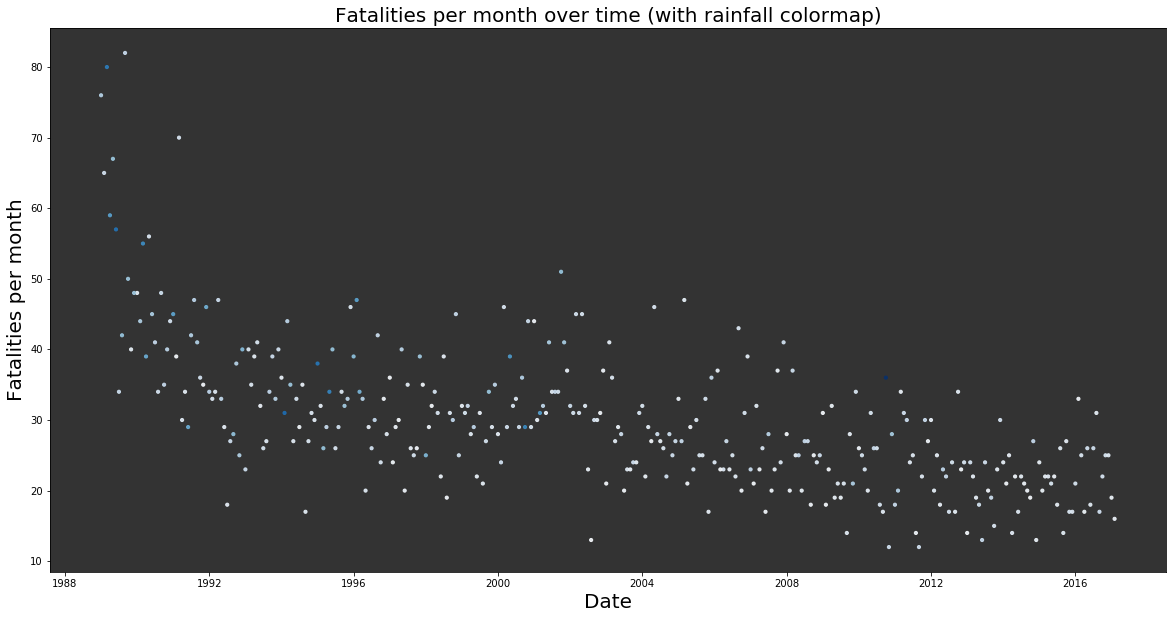

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))

# Graph title and axis labels
plt.title("Fatalities per month over time (with rainfall colormap)",fontsize=20)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Fatalities per month",fontsize=20)

c = 0.2                          # Background greyscale colour
ax.set_facecolor((c, c, c, 1))   # Set background colour
fig.set_facecolor((1, 1, 1, 1))  # White axis background

for q in queries:
    print(f"Processing {q}...")
    conn.rollback()         # To prevent previous errors
    cur.execute(queries[q])
    data = cur.fetchall()   # Get the data
    rounding = 1            # Higher values = less points = smoother graph
    data = sorted(
        [
            (
                round(x[0]/rounding)*rounding,  # Round rainfall data
                x[1],                           # Fatalities
                datetime.datetime(x[2],x[3],1)  # Datetime object for nice representation;
                                                #  we discard the day param so that we can
                                                #  get a per-month view
            )
            for x in data
            if (x[0] < 115 and x[1] < 10)       # Magic numbers to remove outliers
        ],
        key=lambda x: x[2]                      # Sorted by date
    )
    
    dates = list({x[2] for x in data})          # Extract unique dates
    crashes = []
    rainfall = []
    for date in dates:
        crashes.append(sum([x[1] for x in data if x[2] == date]))   # Sum of deaths of crashes in that month
        rainfall.append(sum([x[0] for x in data if x[2] == date]))  # Sum of rainfall in that month
    plt.scatter(     # Scatter graph
        dates,       # Dates on x axis
        crashes,     # Crashes on y axis
        c=rainfall,  # Colour is rainfall
        label=q,     # Labelled by state
        alpha=0.9,   # Transparency
        s=10,        # Dot size
        cmap=plt.cm.get_cmap('Blues')  # Colour scale
    )
    print(f"Done {q}.")


# plt.legend()